### Time Series Demand Forecasting

Assume the Manager of a hotel wants to predict how many visitors should he expect next year to accordingly adjust the hotel’s inventories and make a reasonable guess of the hotel’s revenue. Based on the data of the previous years/months/days, (S)he can use time series forecasting and get an approximate value of the visitors. Forecasted value of visitors will help the hotel to manage the resources and plan things accordingly. This data looks at passenger numbers to forecast the next 7 months.

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

<li>AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.</li>
<li>I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.</li>
<li>MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.</li>

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import sklearn.metrics as sklm
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("Train.csv", index_col=0)

df.head(3)

,Datetime,Count
ID,,
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6


In [89]:
df.tail(3)

,Datetime,Count
ID,,
18285,25-09-2014 21:00,702
18286,25-09-2014 22:00,580
18287,25-09-2014 23:00,534


In [90]:
df.shape

(18288, 2)

### Train Test Split

In [91]:
#Subsetting the dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('Train.csv', nrows = 11856)

#Creating train and test set 
#Index 10392 marks the end of October 2013 
train=df[0:10392] 
test=df[10392:]

#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean()

test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

### Subsetting Date Time Index

In [92]:
# Example of selecting the first week of Jan 2013
df["2013-01-01":"2013-01-07"]

,ID,Count
Datetime,,
2013-01-01,3107.5,16.750000
2013-01-02,3131.5,12.166667
2013-01-03,3155.5,11.583333
2013-01-04,3179.5,23.500000
2013-01-05,3203.5,14.666667
2013-01-06,3227.5,7.416667
2013-01-07,3251.5,20.333333


In [93]:
# Example of aggragating at monthly level
df['Count'].resample('M').mean()

Datetime
2012-08-31      2.952381
2012-09-30      4.444444
2012-10-31     10.986559
2012-11-30     15.827778
2012-12-31     15.680108
2013-01-31     18.430108
2013-02-28     22.190476
2013-03-31     23.588710
2013-04-30     34.405556
2013-05-31     45.612903
2013-06-30     57.333333
2013-07-31     74.787634
2013-08-31    100.137097
2013-09-30    120.744444
2013-10-31    139.932796
2013-11-30    141.000000
2013-12-31    157.387097
Freq: M, Name: Count, dtype: float64

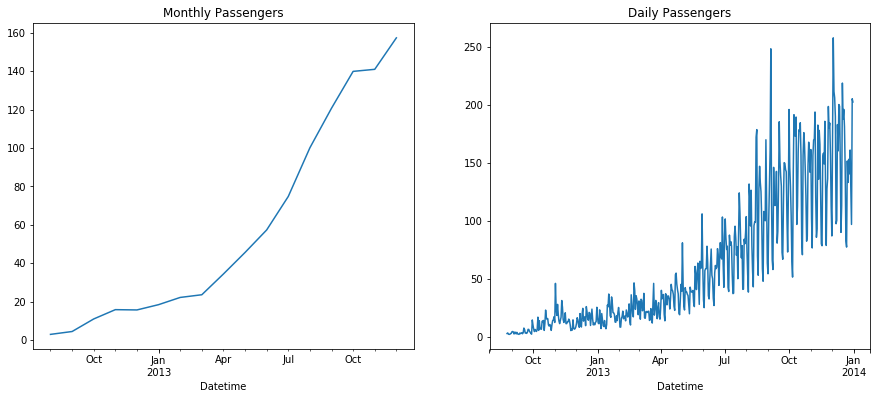

In [94]:
fx, ax = plt.subplots(1, 2, figsize=(15, 6))
df['Count'].resample('M').mean().plot(title="Monthly Passengers", ax=ax[0]);
df['Count'].resample('D').mean().plot(title="Daily Passengers", ax=ax[1]);

### Plotting Trends and Moving Averages

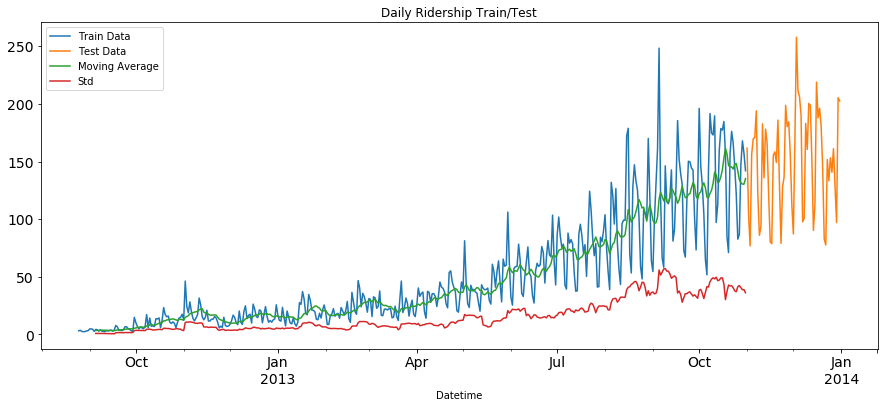

In [95]:
#Plotting data
train.Count.plot(figsize=(15,6), title= 'Daily Ridership Train/Test', fontsize=14)
test.Count.plot(figsize=(15,6), title= 'Daily Ridership Train/Test', fontsize=14)

#Plotting moving averages
train.Count.rolling(window=12).mean().plot()

#Plotting standard deviation
train.Count.rolling(window=12).std().plot()

plt.legend(['Train Data','Test Data','Moving Average','Std'])
plt.show()

### Decomposition into Trend, Seasonality, Residual

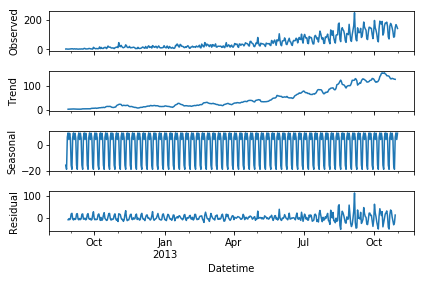

In [96]:
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

### Naive Model

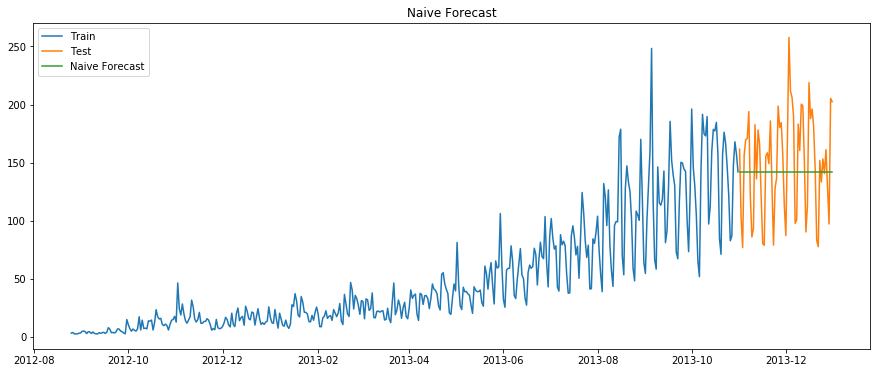

In [97]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(15,6))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [98]:
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print("RMSE = " + str(rms))
print("R^2  = " + str(sklm.r2_score(test.Count, y_hat.naive)))

RMSE = 43.91640614391676
R^2  = -0.028639469900951564


### Holt Linear Trend Model

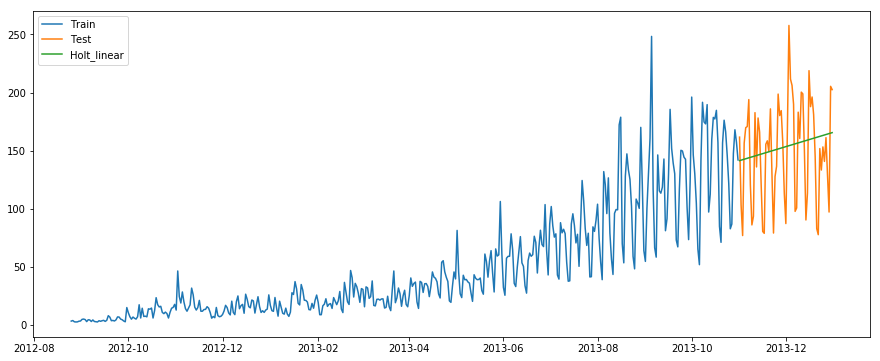

In [99]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(15,6))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [100]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print("RMSE = " + str(rms))
print("R^2  = " + str(sklm.r2_score(test.Count, y_hat_avg.Holt_linear)))

RMSE = 43.056259611507286
R^2  = 0.011259788482330224


### Holt Winter Model

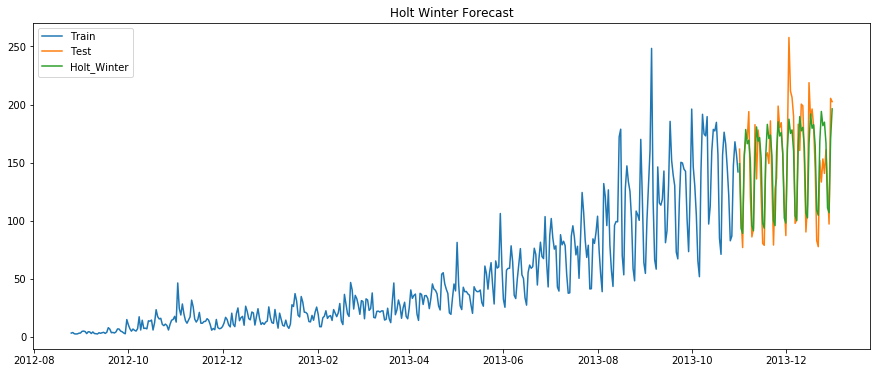

In [101]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(15,6))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.title("Holt Winter Forecast")
plt.legend(loc='best')
plt.show()

In [102]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print("RMSE = " + str(rms))
print("R^2  = " + str(sklm.r2_score(test.Count, y_hat_avg.Holt_Winter)))

RMSE = 23.961492566159794
R^2  = 0.6937773343760462


### Seasonal ARIMA Model

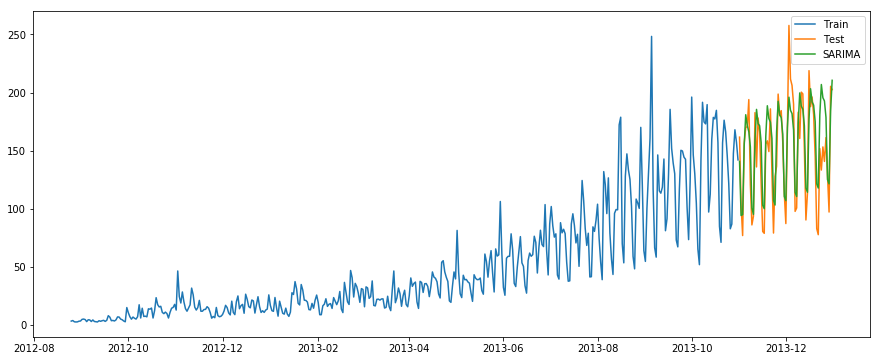

In [103]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(15,6))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [104]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print("RMSE = " + str(rms))
print("R^2  = " + str(sklm.r2_score(test.Count, y_hat_avg.SARIMA)))

RMSE = 26.043862696311677
R^2  = 0.6382401265404044


### ARIMA Diagnostics

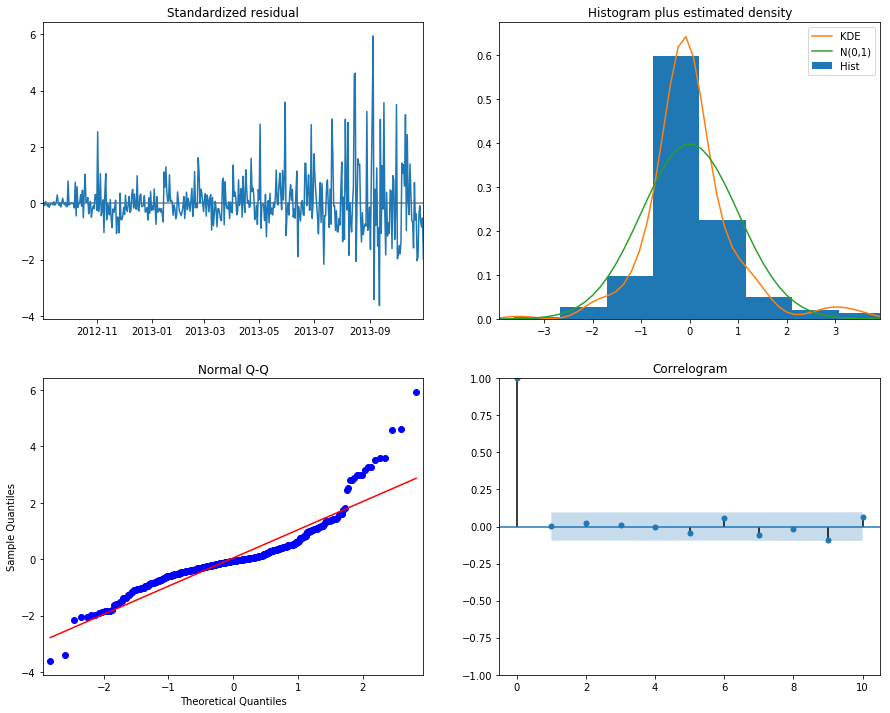

In [105]:
fig = fit1.plot_diagnostics(figsize=(15, 12))

Ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

<li>In the top right plot, the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.</li>
<li>The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.</li>
<li>The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.</li></br>

Those observations lead us to conclude that the model produces a satisfactory fit that could help understand the data and forecast future values.

### Prediction

Predicting the next 7 months to create a forecast of passenger demand.

In [106]:
df = pd.read_csv("Train.csv")

#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()

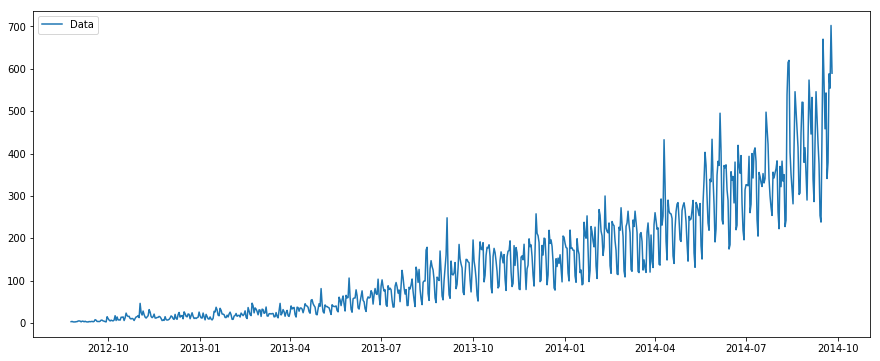

In [107]:
y_hat_avg = df.copy()
plt.figure(figsize=(15,6))
plt.plot(df['Count'], label='Data')
plt.legend(loc='best')
plt.show()

In [108]:
test_data = pd.read_csv("Test.csv")

#Aggregating the dataset at daily level
test_data.Timestamp = pd.to_datetime(test_data.Datetime,format='%d-%m-%Y %H:%M') 
test_data.index = test_data.Timestamp 
test_data = test_data.resample('D').mean()

test_data.head(3)

,ID
Datetime,
2014-09-26,18299.5
2014-09-27,18323.5
2014-09-28,18347.5


In [109]:
test_data.tail()

,ID
Datetime,
2015-04-22,23291.5
2015-04-23,23315.5
2015-04-24,23339.5
2015-04-25,23363.5
2015-04-26,23387.5


In [110]:
# predict using seasonal ARIMA model
fit1 = sm.tsa.statespace.SARIMAX(df.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
test_data['SARIMA'] = fit1.predict(start="2014-09-26", end="2015-04-26", dynamic=True)

In [111]:
# forecast using Holt Winter model
fit1 = ExponentialSmoothing(np.asarray(df['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
test_data['Holt Winter'] = fit1.forecast(len(test_data))

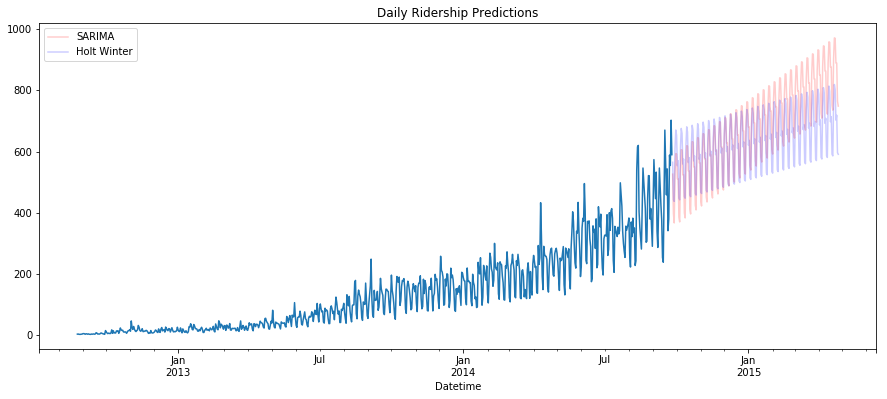

In [112]:
plt.figure(figsize=(15,6))
df['Count'].plot();
plt.title("Daily Ridership Predictions")
test_data['SARIMA'].plot(color="Red", legend=True, alpha=0.2);
test_data['Holt Winter'].plot(color="Blue", legend=True, alpha=0.2);

In [113]:
# daily predictions
predictions = test_data.drop(columns='ID')

# average of two models
predictions['Average'] = (predictions['SARIMA'] + predictions['Holt Winter']) / 2

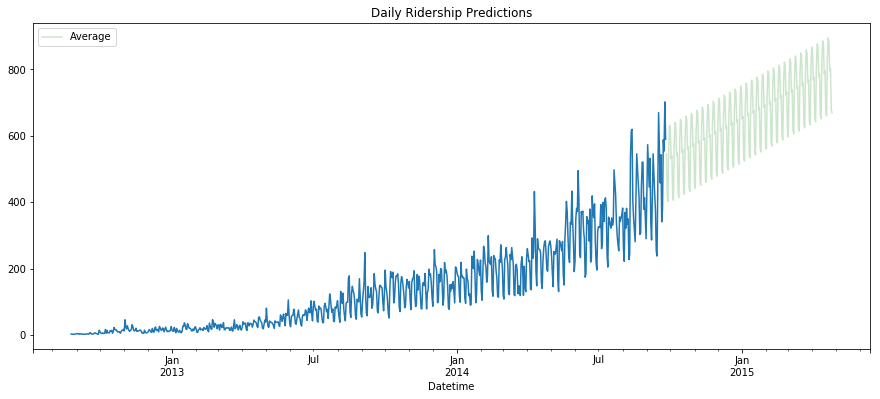

In [114]:
plt.figure(figsize=(15,6))
df['Count'].plot();
plt.title("Daily Ridership Predictions")
predictions['Average'].plot(color="Green", legend=True, alpha=0.2);

In [116]:
predictions

,SARIMA,Holt Winter,Average
Datetime,,,
2014-09-26,525.850249,564.849019,545.349634
2014-09-27,396.081687,442.417113,419.249400
2014-09-28,366.546709,437.076690,401.811699
2014-09-29,527.222635,609.502895,568.362765
2014-09-30,593.167917,670.339731,631.753824
2014-10-01,591.566573,653.551484,622.559029
2014-10-02,510.644112,553.764458,532.204285
2014-10-03,510.717633,569.973780,540.345706
2014-10-04,385.649884,447.541874,416.595879


In [115]:
predictions.describe()

,SARIMA,Holt Winter,Average
count,213.000000,213.000000,213.000000
mean,683.650949,635.941357,659.796153
std,142.831617,96.990916,116.894146
min,366.546709,437.076690,401.811699
25%,588.965976,565.195704,578.674316
50%,683.018787,650.500980,659.432185
75%,788.662970,708.342315,749.763884
max,971.340725,818.957788,895.149256
